In [91]:
#Used for displaying plots below the cell, inverts %matplotlib inline
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sn

#Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering

#Models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from wittgenstein import RIPPER
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, learning_curve, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, \
    classification_report

#visualize the decision tree obtained 
import pydotplus 
from IPython.display import Image

In [2]:
vendor_df_num = pd.read_csv('./task1-result_num_wo_out.csv', sep=',', index_col=[0,1])
vendor_df_cat = pd.read_csv('./task1-result_cat_wo_out.csv', sep=',', index_col=[0,1])

#Used for retrieving the outliers from task 1
vendor_df_num_w_out = pd.read_csv('./task1-result_num_w_out.csv', sep=',', index_col=[0,1])
vendor_df_cat_w_out = pd.read_csv('./task1-result_cat_w_out.csv', sep=',', index_col=[0,1])

df_ram = pd.read_csv('./ram.csv', sep=',', index_col=0)
df_geo = pd.read_csv('./geography.csv', sep=',', index_col=0)

## Categorical features discretisation

In [3]:
vendor_df_cat_discr = vendor_df_cat.copy()
vendor_df_cat_discr_w_out = vendor_df_cat_w_out.copy()

### TopBrand

In [4]:
vendor_df_cat_discr.head()

,,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,
1,1stWave Technologies,CORSAIR,New Zeland,NZD,11
2,Adorama,CRUCIAL,United States of America,USD,4
3,Alternate,G.SKILL,France,EUR,3
4,Alternate Italia,G.SKILL,Italy,EUR,3
5,Alza,KINGSTON,United Kingdom,GBP,12


In [5]:
brand_names = sorted(df_ram["brand"].unique())
brand_map = dict(zip(brand_names, range(len(brand_names))))

vendor_df_cat_discr.loc[:, "TopBrand"] = vendor_df_cat_discr["TopBrand"].transform(lambda x, feat_map=brand_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopBrand"] = vendor_df_cat_discr_w_out["TopBrand"].transform(lambda x, feat_map=brand_map: feat_map[x])

### TopCountry

In [6]:
vendor_df_cat_discr.head()

,,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,
1,1stWave Technologies,9,New Zeland,NZD,11
2,Adorama,10,United States of America,USD,4
3,Alternate,17,France,EUR,3
4,Alternate Italia,17,Italy,EUR,3
5,Alza,30,United Kingdom,GBP,12


In [7]:
country_names = sorted(df_geo["country"].unique())
country_map = dict(zip(country_names, range(len(country_names))))

vendor_df_cat_discr.loc[:, "TopCountry"] = vendor_df_cat_discr["TopCountry"].transform(lambda x, feat_map=country_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopCountry"] = \
        vendor_df_cat_discr_w_out["TopCountry"].transform(lambda x, feat_map=country_map: feat_map[x])

### TopCurrency

In [8]:
vendor_df_cat_discr.head()

,,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,
1,1stWave Technologies,9,7,NZD,11
2,Adorama,10,10,USD,4
3,Alternate,17,3,EUR,3
4,Alternate Italia,17,6,EUR,3
5,Alza,30,9,GBP,12


In [9]:
currency_names = sorted(df_geo["currency"].unique())
currency_map = dict(zip(currency_names, range(len(currency_names))))

vendor_df_cat_discr.loc[:, "TopCurrency"] = vendor_df_cat_discr["TopCurrency"].transform(lambda x, feat_map=currency_map: feat_map[x])
vendor_df_cat_discr_w_out.loc[:, "TopCurrency"] = \
        vendor_df_cat_discr_w_out["TopCurrency"].transform(lambda x, feat_map=currency_map: feat_map[x])

### TopSalesMonth

In [10]:
vendor_df_cat_discr.head()

,,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,
1,1stWave Technologies,9,7,4,11
2,Adorama,10,10,5,4
3,Alternate,17,3,2,3
4,Alternate Italia,17,6,2,3
5,Alza,30,9,3,12


Already expressed in numerical values, ready to be normalised.

### Merge all features in a single dataset

In [11]:
vendor_df = pd.concat([vendor_df_num, vendor_df_cat_discr], axis=1)
vendor_df_w_out = pd.concat([vendor_df_num_w_out, vendor_df_cat_discr_w_out], axis=1)

## Normalisation

In [12]:
vend_scaler = MinMaxScaler()
vend_scaler.fit(vendor_df.values)
vendor_norm = vend_scaler.transform(vendor_df.values)
vendor_df_norm = pd.DataFrame(vendor_norm, columns=vendor_df.columns, index=vendor_df.index)

## Auxiliary functions

In [13]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                    test_pred, 
                    target_names=['big-seller', 'small-seller']))

## Define big-seller/small-seller label

In [14]:
vendor_df.head()

,,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,,,,,,,,,,,
1,1stWave Technologies,774,60,565.439098,132.989886,13.074935,4117.366865,25,5.361843,0.643988,0.643988,9,7,4,11
2,Adorama,3274,186,1761.990000,146.248003,14.628894,23940.798168,20,6.754711,0.000000,0.000000,10,10,5,4
3,Alternate,3047,203,860.154236,155.134195,11.530030,157564.631150,3,7.373634,1.679995,0.000000,17,3,2,3
4,Alternate Italia,407,101,774.077840,142.140184,10.034398,28925.527422,2,6.486558,0.898296,0.898296,17,6,2,3
5,Alza,12959,276,1188.115658,166.036705,13.514777,126568.803904,17,7.612859,1.165894,1.094659,30,9,3,12


What defines a seller as big?  
Let's start by taking a look at the labels in the results of the clustering task.

In [15]:
clust_labels = AgglomerativeClustering(n_clusters=2, linkage="average").fit(vendor_norm).labels_
clust_labels_df = vendor_df_norm.copy()
clust_labels_df.loc[:, "Label"] = -1

for i in range(len(clust_labels)):
    
    if clust_labels[i] == 0:
        clust_labels_df.iloc[i, -1] = "small-seller"
    else:
        clust_labels_df.iloc[i, -1] = "big-seller"

In [16]:
clust_labels_df.loc[clust_labels_df["Label"] == "small-seller"].max()

I                             1.0
Iu                            1.0
MaxValuePerOrder              1.0
AvgValuePerOrder              1.0
AvgMemoryPerOrder             1.0
IAvgMonthSales                1.0
TotMonthBusiness              1.0
Eram                          1.0
Egeo                          1.0
Ecur                          1.0
TopBrand                      0.5
TopCountry                    1.0
TopCurrency                   1.0
TopSalesMonth                 1.0
Label                small-seller
dtype: object

In [17]:
clust_labels_df.loc[clust_labels_df["Label"] == "big-seller"].min()

I                           0.0
Iu                          0.0
MaxValuePerOrder            0.0
AvgValuePerOrder       0.072133
AvgMemoryPerOrder      0.091182
IAvgMonthSales         0.000419
TotMonthBusiness            0.0
Eram                        0.0
Egeo                        0.0
Ecur                        0.0
TopBrand                    1.0
TopCountry                  1.0
TopCurrency                 1.0
TopSalesMonth          0.818182
Label                big-seller
dtype: object

We will take inspiration from the clustering results and define the **big-seller/small-seller** labels by using the **I/IAvgMonthSales** .  

Unfortunately, if we were to perfectly adhere to the clustering results, the number of samples in the **big-seller** label is too low to perform any meaningful predictive analysis.  
We will therefore expand the meaning of **big-seller**, currently dominated by the **I** feature (note the min and max of **I** for each label), to also include entries that have a relatively low **I** but a high **IAvgSalesMonth** value.

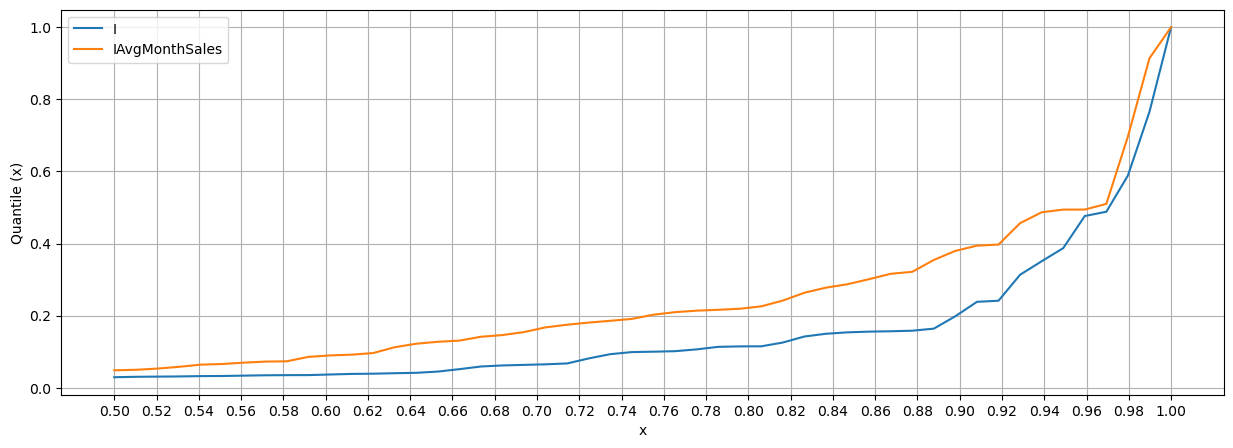

In [18]:
key_features = ["I", "IAvgMonthSales"]
pred_label_df = vendor_df_norm.copy()

pred_label_df[key_features].quantile(np.linspace(0.5, 1, 50)).plot(figsize=(15,5), grid=True)
plt.xlabel("x")
plt.ylabel("Quantile (x)")
plt.xticks(np.arange(0.5, 1.02, 0.02))
plt.show()

In [19]:
pred_label_df["Label"] = "small-seller"

pred_label_df.loc[pred_label_df["I"] >= pred_label_df["I"].quantile(0.80), "Label"] = "big-seller"
pred_label_df.loc[pred_label_df["IAvgMonthSales"] >= pred_label_df["IAvgMonthSales"].quantile(0.90), "Label"] = "big-seller"

pred_label_df.groupby("Label").size()

Label
big-seller      16
small-seller    59
dtype: int64

We decide to go with:
- big-seller: any entry having **I** >= quantile(0.8) or **IAvgMonthSales** >= quantile(0.8) of the whole dataset
- small-seller: everything else

We decided to go for this definition based on the above plot, in which the values of these features start to take off (forming a knee) around that value.  
This definition doubles the amount of data points that we have to work with when it comes to the **big-seller** label.

In [20]:
small_seller_df_norm = pred_label_df.loc[pred_label_df["Label"] == "small-seller"]
small_seller_df_norm.describe()

,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.027195,0.112363,0.160053,0.264247,0.361157,0.068316,0.595339,0.518504,0.292167,0.259680,0.178370,0.576271,0.501695,0.451464
std,0.028808,0.096034,0.121216,0.222967,0.211379,0.085802,0.380786,0.205527,0.204815,0.218184,0.224417,0.404432,0.364593,0.351265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005920,0.036977,0.063853,0.122839,0.209956,0.012075,0.208333,0.416818,0.192710,0.000000,0.000000,0.050000,0.100000,0.181818
50%,0.018712,0.088424,0.124713,0.172221,0.320440,0.038242,0.666667,0.566039,0.328149,0.300021,0.023810,0.700000,0.600000,0.272727
75%,0.035073,0.165997,0.259288,0.347845,0.476771,0.080837,1.000000,0.672809,0.368002,0.394126,0.190476,0.900000,0.800000,0.818182
max,0.113253,0.543408,0.492266,1.000000,1.000000,0.368735,1.000000,0.899448,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
big_seller_df_norm = pred_label_df.loc[pred_label_df["Label"] == "big-seller"]
big_seller_df_norm.describe()

,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.312479,0.408762,0.336851,0.248761,0.431251,0.397517,0.882812,0.782936,0.299745,0.303996,0.328869,0.562500,0.512500,0.477273
std,0.247203,0.257505,0.242397,0.120629,0.095910,0.251342,0.180161,0.117875,0.127232,0.160005,0.210499,0.359398,0.318067,0.308734
min,0.114889,0.165595,0.153306,0.127989,0.308643,0.129627,0.500000,0.644442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.154051,0.225683,0.164017,0.179757,0.362183,0.210666,0.864583,0.682351,0.264957,0.291278,0.190476,0.200000,0.200000,0.250000
50%,0.202028,0.303457,0.291883,0.211621,0.405553,0.357635,1.000000,0.759081,0.351979,0.385131,0.500000,0.700000,0.600000,0.545455
75%,0.390255,0.481310,0.324304,0.292474,0.503459,0.494118,1.000000,0.892422,0.386953,0.426001,0.500000,0.900000,0.800000,0.659091
max,1.000000,1.000000,1.000000,0.639707,0.607392,1.000000,1.000000,1.000000,0.390736,0.431248,0.500000,1.000000,1.000000,1.000000


## Feature correlations

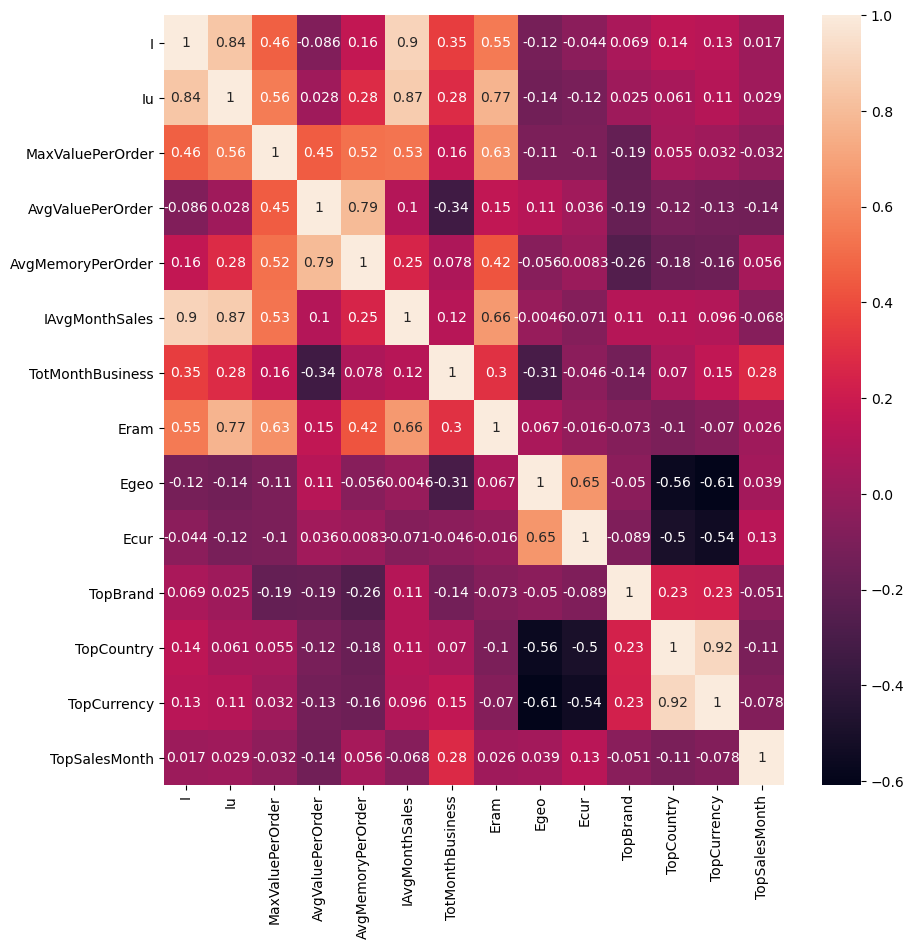

In [22]:
plt.figure(figsize=(10,10))
sn.heatmap(vendor_df.corr(), annot=True)
plt.show()

## Dataset preparation

### Add outliers  

In [23]:
outlier_df = vendor_df_w_out.loc[~vendor_df_w_out.index.isin(vendor_df.index)]
outlier_df

,,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,,,,,,,,,,,
32,geizhals_unknown,2020083,1733,10630.741494,164.006403,14.541547,5.343654e+06,62,10.512789,0.337642,0.000000,17,4,2,3
43,Mindfactory,248228,774,6044.234544,207.345263,19.361700,2.058756e+06,25,9.189418,0.334336,0.000000,17,4,2,1
68,pricespy_unknown,318591,1659,4465.589602,220.574502,20.171635,1.849291e+06,38,10.118133,0.441207,0.441207,9,9,3,3


We already know from our analysis that the outliers from Task 1 present extreme values in the **I/IAvgSalesMonth** features, therefore it seems only natural to include them as **big-sellers**.

In [24]:
vend_w_out_scaler = StandardScaler()
vend_w_out_norm = vend_w_out_scaler.fit_transform(vendor_df_w_out.values)
vend_w_out_df_norm = pd.DataFrame(vend_w_out_norm, columns=vendor_df_w_out.columns, index=vendor_df_w_out.index)

vend_w_out_df_norm.head()

,,I,Iu,MaxValuePerOrder,AvgValuePerOrder,AvgMemoryPerOrder,IAvgMonthSales,TotMonthBusiness,Eram,Egeo,Ecur,TopBrand,TopCountry,TopCurrency,TopSalesMonth
vendor_code,name,,,,,,,,,,,,,,
1,1stWave Technologies,-0.182784,-0.625345,-0.676333,-0.729306,-0.648874,-0.314942,0.709453,-0.683483,0.496859,0.779285,-0.925129,0.329216,0.863271,1.373472
2,Adorama,-0.171925,-0.245242,0.090633,-0.569198,-0.308858,-0.285252,0.222328,0.088941,-1.565545,-1.273951,-0.818855,1.107364,1.443747,-0.506016
3,Alternate,-0.172911,-0.193958,-0.487426,-0.461887,-0.986908,-0.085125,-1.433894,0.432169,3.814725,-1.273951,-0.074937,-0.708314,-0.297680,-0.774514
4,Alternate Italia,-0.184378,-0.501660,-0.542600,-0.618805,-1.314161,-0.277787,-1.531318,-0.059765,1.311293,1.590099,-0.074937,0.069834,-0.297680,-0.774514
5,Alza,-0.129857,0.026261,-0.277209,-0.330226,-0.552633,-0.131547,-0.069946,0.564833,2.168290,2.216167,1.306626,0.847981,0.282796,1.641970


This time we choose to use a StandardScaler instead of a MinMaxScaler given its better handling of outliers and because the focus of this task is not the direct interpretability of these values but the behaviour of each model.

In [25]:
vend_w_out_df_norm.loc[big_seller_df_norm.index, "Label"] = "big-seller"
vend_w_out_df_norm.loc[outlier_df.index, "Label"] = "big-seller"

vend_w_out_df_norm.loc[small_seller_df_norm.index, "Label"] = "small-seller"

### Removal of features used to define labels

In [26]:
pred_df = vend_w_out_df_norm.copy().drop(["I", "IAvgMonthSales", "Iu"], axis=1)
labels = pred_df.pop('Label')

We also tried removing the **Iu** feature given its high correlation with the features removed, however the results were very lackluster across the board probably pointing out that the other features are not correlated enough with the missing ones to correctly learn the labels or that there are not enough data points to retrieve them.  
The crucial assumption being that if a model is capable of generalising sufficiently it shouldn't have a problem dealing with data points 

### PCA

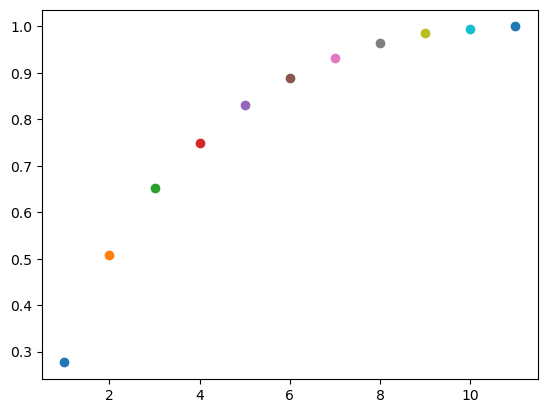

In [27]:
for i in range(1, len(pred_df.columns) + 1):
    pca = PCA(n_components=i)
    pca.fit(pred_df.values)
    plt.scatter(i, np.sum(pca.explained_variance_ratio_))

After 4 components we start to get diminishing returns.

In [28]:
pca = PCA(n_components=4)
pred_pca = pca.fit_transform(pred_df.values)
pred_df_pca = pd.DataFrame(pred_pca, index=pred_df.index)

### Train/test split

In [29]:
#Non-normalised data
train_set, test_set, train_label, test_label = train_test_split(pred_df, labels, stratify=labels, test_size=0.3)
#PCA data
train_set_pca, test_set_pca, train_label_pca, test_label_pca = train_test_split(pred_df_pca, labels, stratify=labels, test_size=0.3)

print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 54
Test set size: 24


## Decision trees

### Grid search

We use grid search to find the optimal parameters for the decision trees.  

We already decided the range of parameters in which to search, mostly because the number of data points available is very low and this makes it very easy to overfit the model.  
Therefore we chose to set the min_samples_leaf value to 1, following the rule of thumb for small datasets and limit the number of features to the interval [2,3,4], since for an increase in the number of features a dt needs a a lot of data to avoid overfitting, the lower limit is due to the fact that we know given the correlations of the features, that no single feature has a strong enough correlation to explain the hidden behaviour.  

We also decided to use the "balanced" value for the class_weight parameter in order to take the support of each label into account when calculating the metrics result.  
The other parameters will be selected by an exhaustive search of the parameter space since it is pretty small to begin with.

In [30]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": [2, 3, 4],
              "min_samples_split": range(2, 10),
              "min_samples_leaf": [1],
              "max_features": [2, 3, 4],
              "criterion": ["gini", "entropy"],
              "class_weight": ["balanced"]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt.fit(train_set, train_label)

print('Best settings parameters ', grid_search_dt.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt.cv_results_['mean_test_score'][0], 
      grid_search_dt.cv_results_['std_test_score'][0])

Best settings parameters  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 4}
Setting's accuracy score mean and std  0.6672727272727274 0.06937739646668697


The variance that can be seen by running the GridSearch a number of times is due to the tendency of decision trees to alter dramatically their structure for each perturbation of the training set (in this case as a consequence of cross validation).  
This is one of the reasons for the success of random forests compared to single decision trees.

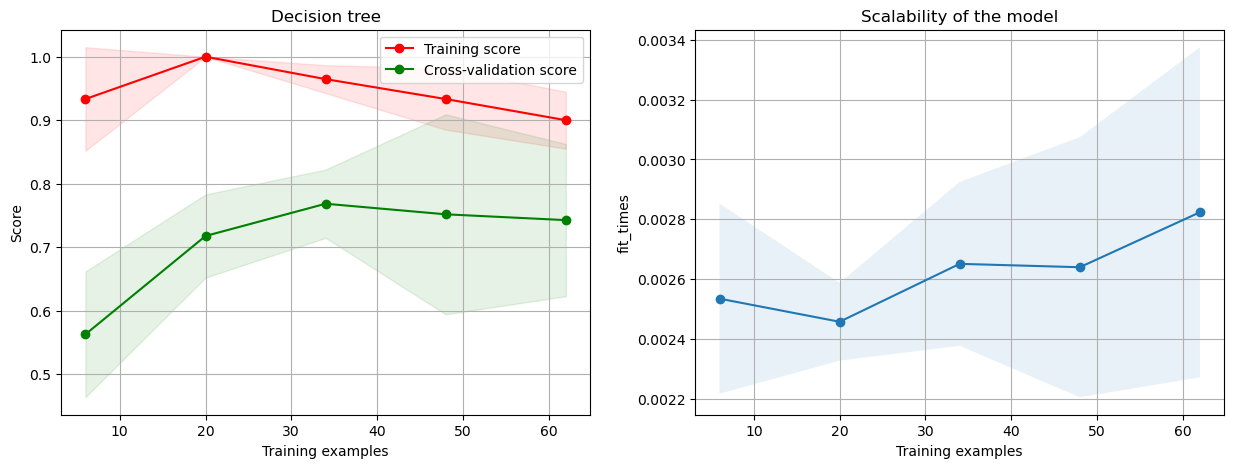

In [31]:
#define a decision tree with the parameters found and fit it
dt = tree.DecisionTreeClassifier(**grid_search_dt.best_params_)

plot_learning_curve(dt, "Decision tree", pred_df, labels)
plt.show()

The learning curve suggests, through the upward direction of the cv score, that the model would benefit from more data points, as we pointed out above.

In [32]:
dt.fit(train_set, train_label)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_features=4, min_samples_split=4)

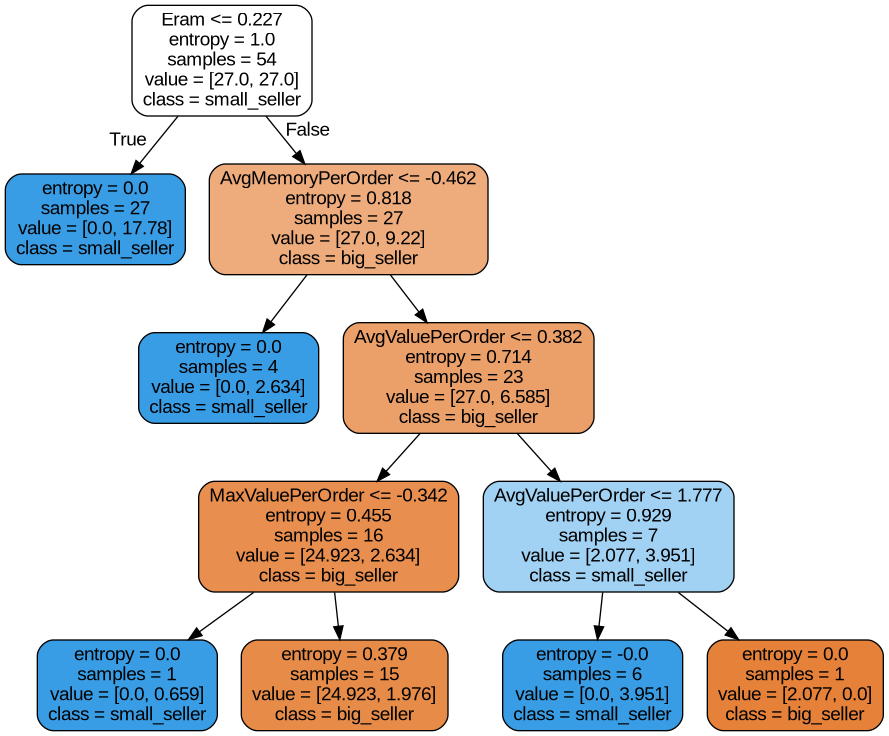

In [33]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### Evaluation

In [34]:
test_pred_dt = dt.predict(test_set)
test_pred_proba_dt = dt.predict_proba(test_set)

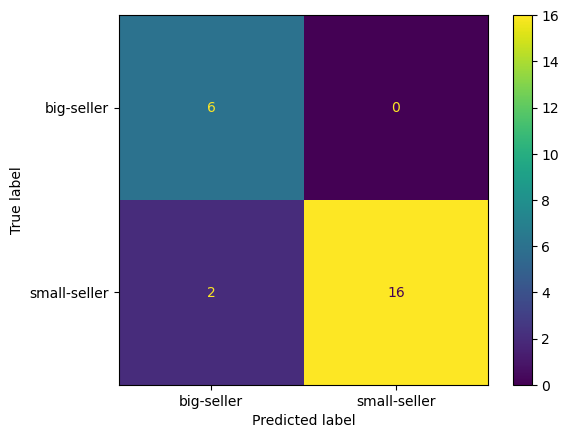

In [35]:
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

In [36]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  big-seller       0.75      1.00      0.86         6
small-seller       1.00      0.89      0.94        18

    accuracy                           0.92        24
   macro avg       0.88      0.94      0.90        24
weighted avg       0.94      0.92      0.92        24



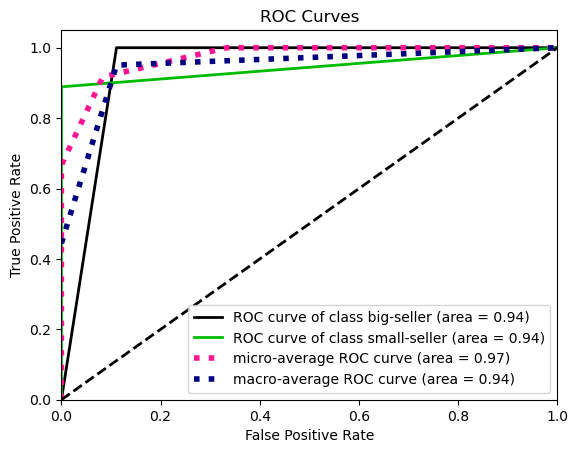

In [37]:
skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt)
plt.show()

## Naives Bayes classifier (GaussianNB)

In [38]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

test_pred_gnb = gnb.predict(test_set)
test_pred_proba_gnb = gnb.predict_proba(test_set)

In [39]:
gnb.class_prior_

array([0.24074074, 0.75925926])

In [40]:
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  big-seller       0.67      0.67      0.67         6
small-seller       0.89      0.89      0.89        18

    accuracy                           0.83        24
   macro avg       0.78      0.78      0.78        24
weighted avg       0.83      0.83      0.83        24



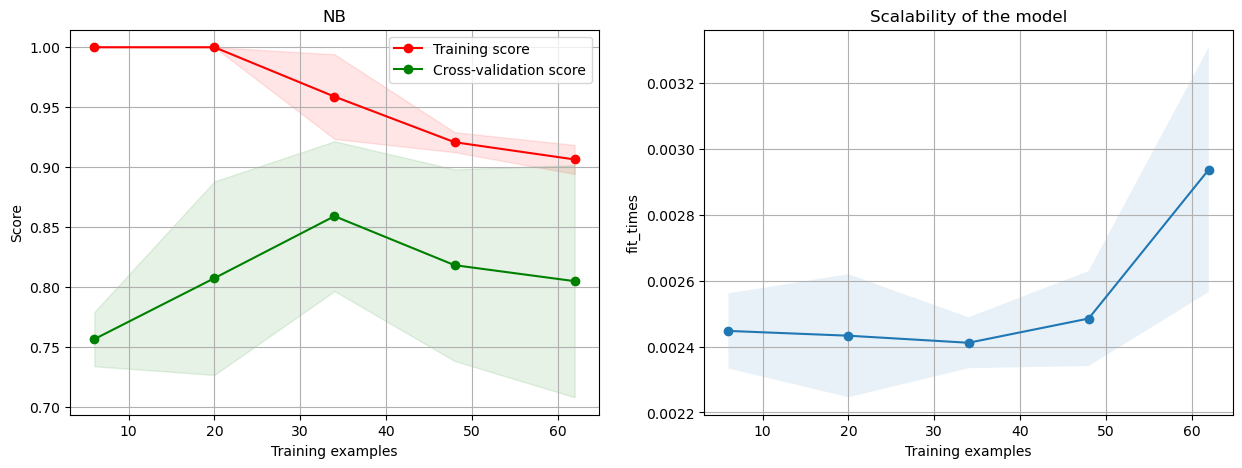

In [41]:
plot_learning_curve(gnb, "NB", pred_df, labels)
plt.show()

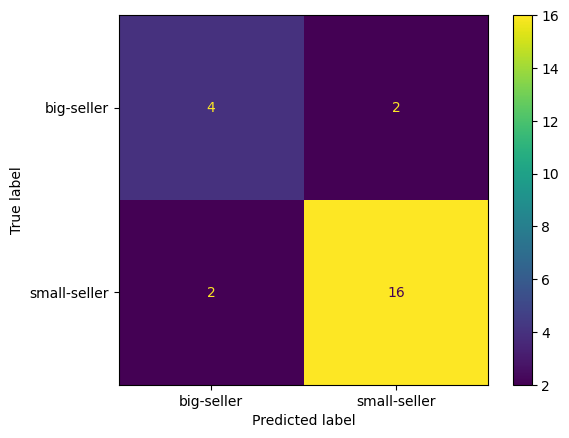

In [42]:
plot_confusion_matrix(gnb, test_set, test_label)
plt.show() 

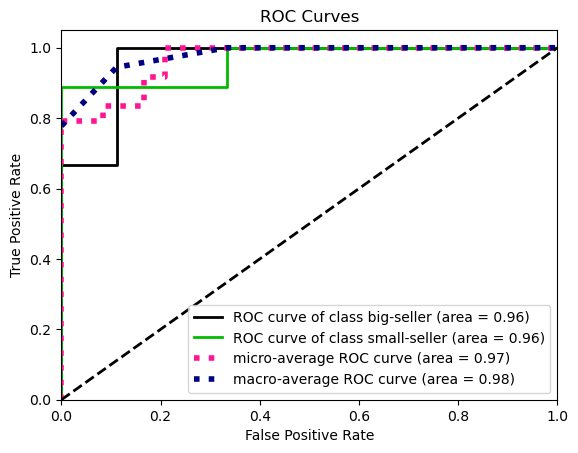

In [43]:
skplt.metrics.plot_roc(test_label.values, test_pred_proba_gnb)
plt.show()

## Random forest

### Randomized search

In [44]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 30, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, pred_df.shape[1] + 1),
              "max_depth": range(1, 5), 
              "min_samples_split": range(2, 5),
              "min_samples_leaf": range(1, 5),
              "bootstrap": [True], 
              "class_weight": ["balanced"]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf.cv_results_['mean_test_score'][0], 
      grid_search_rf.cv_results_['std_test_score'][0])

Best settings parameters  {'n_estimators': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}
Setting's accuracy score mean and std  0.8 0.13360853142453696


In [45]:
rf = RandomForestClassifier(**grid_search_rf.best_params_) 
rf = rf.fit(train_set, train_label)

test_pred_rf = rf.predict(test_set)
test_pred_proba_rf = rf.predict_proba(test_set)

In [46]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  big-seller       0.42      0.83      0.56         6
small-seller       0.92      0.61      0.73        18

    accuracy                           0.67        24
   macro avg       0.67      0.72      0.64        24
weighted avg       0.79      0.67      0.69        24



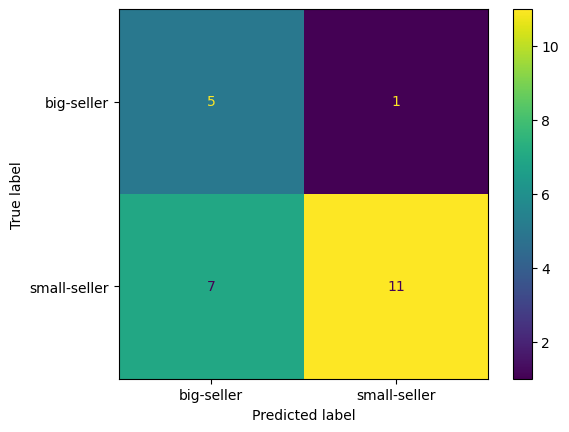

In [47]:
#it is possible to plot the confusion matrix
plot_confusion_matrix(rf, test_set, test_label)
plt.show() 

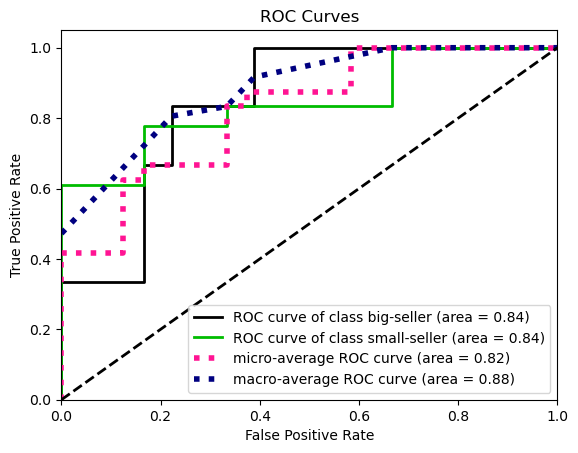

In [48]:
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf)
plt.show()

## Classification with K-NN

In [49]:
#define the parameters' values you want to try
param_dist_knn = {
    'n_neighbors': [int(np.ceil(np.sqrt(pred_df.shape[1])))],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }
#define the model
clf = KNeighborsClassifier()
#define the grid search
grid_search_knn = RandomizedSearchCV(clf, param_distributions=param_dist_knn,
                            n_jobs=-1,
                            n_iter=12,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_knn.fit(train_set, train_label)

print('Best settings parameters ', grid_search_knn.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_knn.cv_results_['mean_test_score'][0], 
      grid_search_knn.cv_results_['std_test_score'][0])

Best settings parameters  {'weights': 'uniform', 'n_neighbors': 4, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Setting's accuracy score mean and std  0.8345454545454546 0.06615783781331


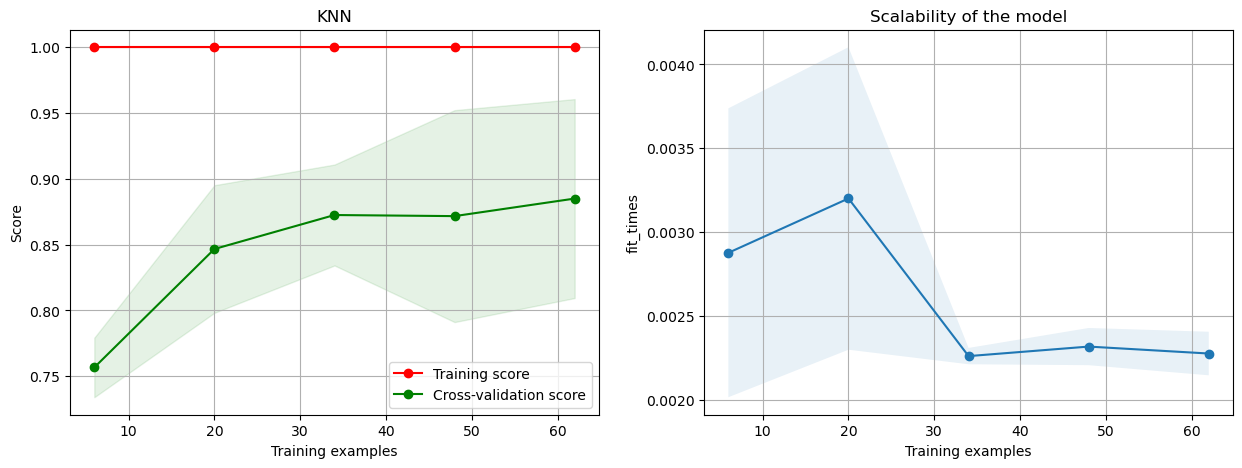

In [50]:
knn = KNeighborsClassifier(**grid_search_knn.best_params_).fit(train_set, train_label)

plot_learning_curve(knn, "KNN", pred_df, labels)
plt.show()

In [51]:
test_pred_knn = knn.predict(test_set)
test_pred_proba_knn = knn.predict_proba(test_set)

In [52]:
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



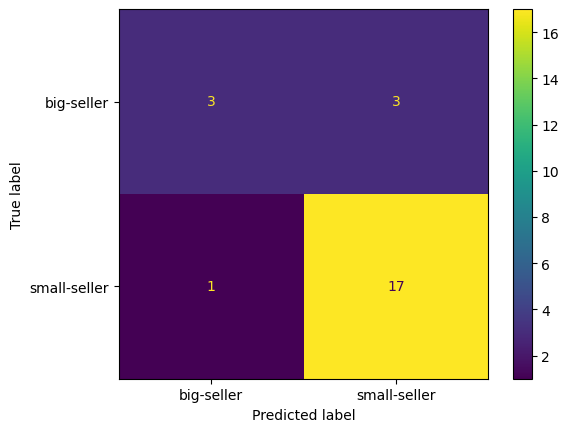

In [53]:
plot_confusion_matrix(knn, test_set, test_label)
plt.show() 

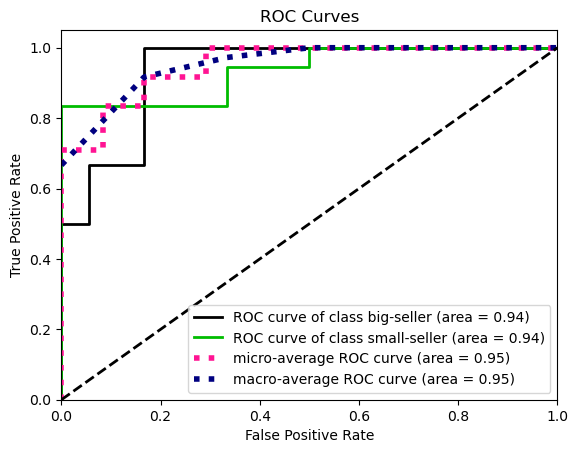

In [54]:
skplt.metrics.plot_roc(test_label.values, test_pred_proba_knn)
plt.show()

### PCA

In [55]:
#define the parameters' values you want to try
param_dist_knn = {
    'n_neighbors': [int(np.ceil(np.sqrt(pred_df_pca.shape[1])))],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }
#define the model
clf = KNeighborsClassifier()
#define the grid search
grid_search_knn = RandomizedSearchCV(clf, param_distributions=param_dist_knn,
                            n_jobs=-1,
                            n_iter=12,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_knn.fit(train_set_pca, train_label_pca)

print('Best settings parameters ', grid_search_knn.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_knn.cv_results_['mean_test_score'][0], 
      grid_search_knn.cv_results_['std_test_score'][0])

Best settings parameters  {'weights': 'uniform', 'n_neighbors': 2, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Setting's accuracy score mean and std  0.650909090909091 0.11579406056793208


The average accuracy decreased.

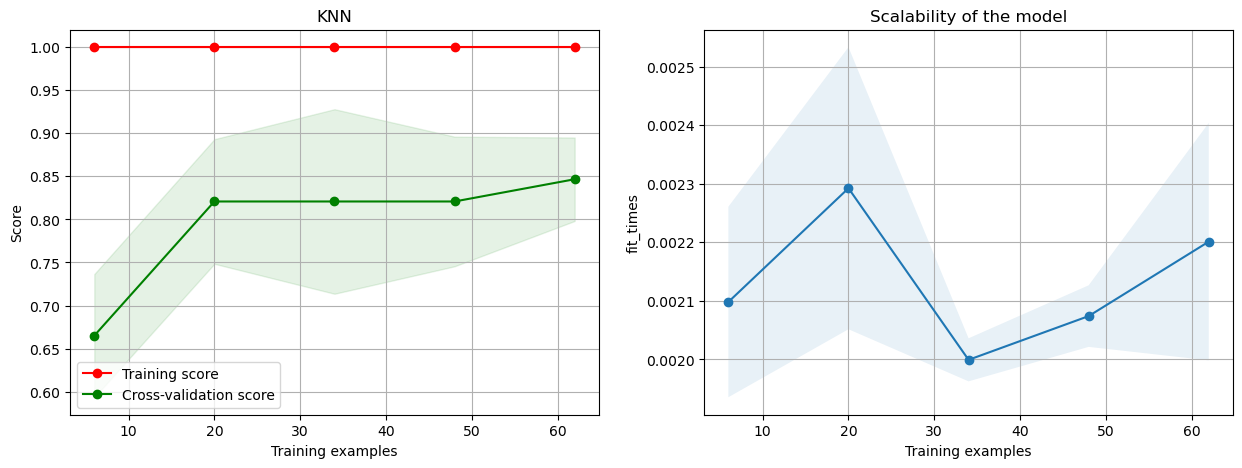

In [56]:
knn_pca = KNeighborsClassifier(**grid_search_knn.best_params_).fit(train_set_pca, train_label_pca)

plot_learning_curve(knn_pca, "KNN", pred_df_pca, labels)
plt.show()

In [57]:
test_pred_knn_pca = knn_pca.predict(test_set_pca)
test_pred_proba_knn_pca = knn_pca.predict_proba(test_set_pca)

In [58]:
report_scores(test_label_pca, test_pred_knn_pca)

              precision    recall  f1-score   support

  big-seller       0.83      0.83      0.83         6
small-seller       0.94      0.94      0.94        18

    accuracy                           0.92        24
   macro avg       0.89      0.89      0.89        24
weighted avg       0.92      0.92      0.92        24



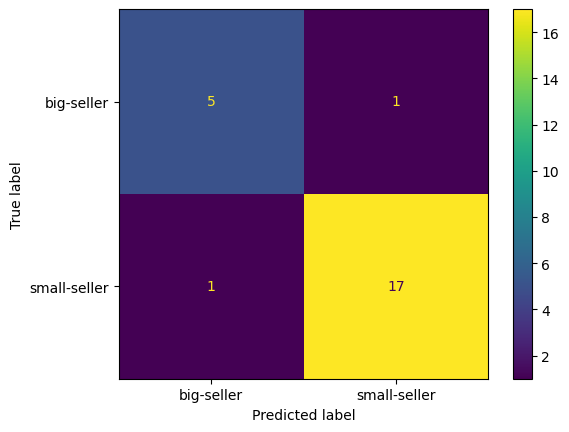

In [59]:
plot_confusion_matrix(knn_pca, test_set_pca, test_label_pca)
plt.show()

Contrary to what we expected, given that KNN can benefit for a dimensionality reduction, PCA worsened the results compared to the non-PCA model.

## Classification with SVM

### Linear

In [67]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 100, 1000), 
    "class_weight": ["balanced"]
}
#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_lin.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin.cv_results_['std_test_score'][0])

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 92.39315315315315}
Setting's accuracy score mean and std  0.8327272727272728 0.03882573909829565


/usr/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/lib/python3.9/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/usr/lib/python3.9/site-packages/sklearn/svm/_base.py", line 558, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class

  warnings.warn("Estimator fit failed. The score on this train-test"


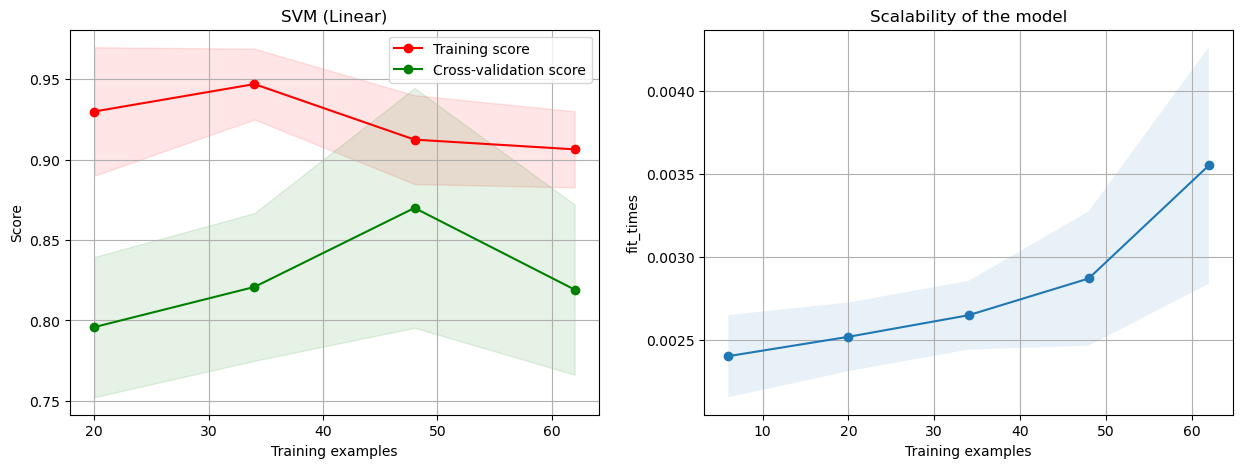

In [68]:
svm_lin = SVC(**grid_search_svm_lin.best_params_)
svm_lin.fit(train_set, train_label)

plot_learning_curve(svm_lin, "SVM (Linear)", pred_df, labels)
plt.show()

In [73]:
#prediction on the test test
test_pred_proba_svm_lin = svm_lin.predict_proba(test_set)
test_pred_svm_lin = svm_lin.predict(test_set)

#compute the performance of the model
report_scores(test_label,test_pred_svm_lin)

              precision    recall  f1-score   support

  big-seller       0.55      1.00      0.71         6
small-seller       1.00      0.72      0.84        18

    accuracy                           0.79        24
   macro avg       0.77      0.86      0.77        24
weighted avg       0.89      0.79      0.81        24



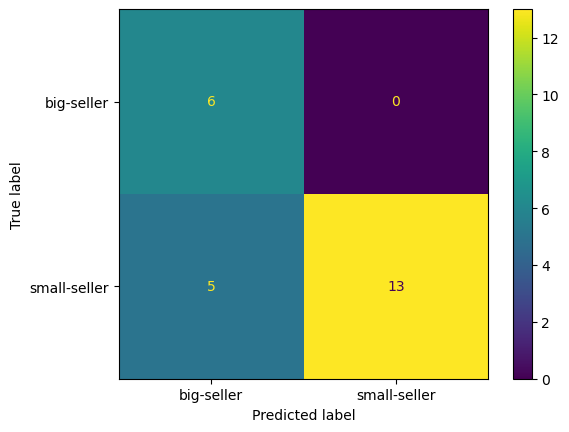

In [74]:
plot_confusion_matrix(svm_lin, test_set, test_label)
plt.show() 

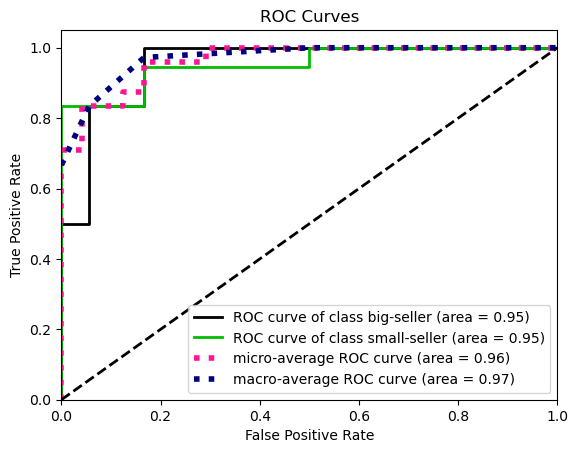

In [65]:
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin)
plt.show()

### RBF

In [79]:
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 100, 1000), 
    "class_weight": ["balanced"]
}

clf = SVC()

grid_search_svm_rbf = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_rbf.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf.cv_results_['std_test_score'][0])

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 13.62225225225225}
Setting's accuracy score mean and std  0.7981818181818182 0.0868931137843529


/usr/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/lib/python3.9/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/usr/lib/python3.9/site-packages/sklearn/svm/_base.py", line 558, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class

  warnings.warn("Estimator fit failed. The score on this train-test"


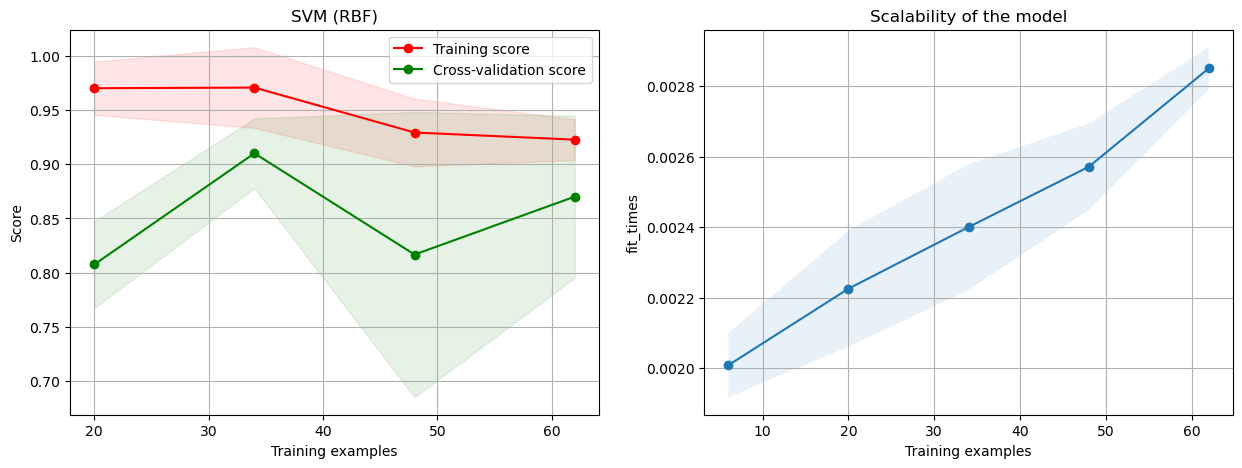

In [94]:
svm_rbf = SVC(**grid_search_svm_rbf.best_params_)
svm_rbf.fit(train_set, train_label)

plot_learning_curve(svm_rbf, "SVM (RBF)", pred_df, labels)
plt.show()

In [93]:
#prediction on the test test
test_pred_proba_svm_rbf = svm_rbf.predict_proba(test_set)
test_pred_svm_rbf = svm_rbf.predict(test_set)

#compute the performance of the model
report_scores(test_label,test_pred_svm_rbf)

              precision    recall  f1-score   support

  big-seller       0.75      1.00      0.86         6
small-seller       1.00      0.89      0.94        18

    accuracy                           0.92        24
   macro avg       0.88      0.94      0.90        24
weighted avg       0.94      0.92      0.92        24



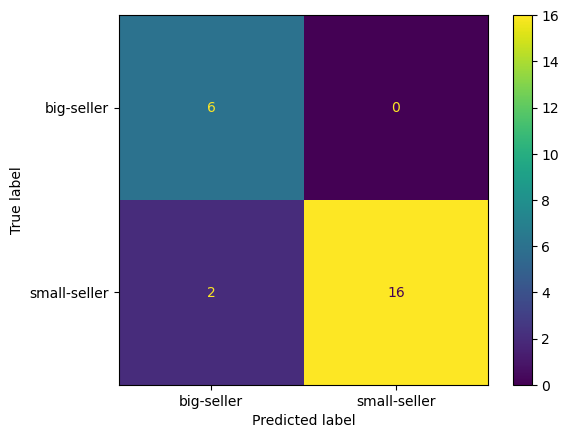

In [82]:
plot_confusion_matrix(svm_rbf, test_set, test_label)
plt.show() 

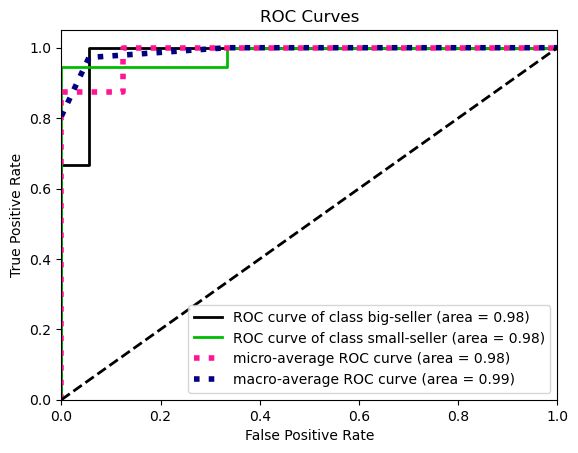

In [83]:
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf)
plt.show()

## Classification with rule based 

### Ripper

In [85]:
ripper = RIPPER()

param_grid_rip = {"prune_size": np.linspace(0.1, 1, 10), 
              "k": range(2, 10)}

grid_search_rip = RandomizedSearchCV(estimator=ripper, 
                                     n_iter=100,
                                     param_distributions=param_grid_rip)

grid_search_rip.fit(train_set, train_label, pos_class="big-seller")

print('Best parameters setting ', grid_search_rip.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rip.cv_results_['mean_test_score'][0], 
      grid_search_rip.cv_results_['std_test_score'][0])

/usr/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rulese

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

Best parameters setting  {'prune_size': 0.1, 'k': 2}
Setting's accuracy score mean and std  0.7254545454545455 0.09627783487180894


ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



In [86]:
#define and fit the rule-based model
#this function requires one dataset with the labels. 
#To do so, we concatenate the train_set and the train_label
datas = pd.concat([train_set, train_label], axis=1)

ripper = RIPPER(**grid_search_rip.best_params_)
ripper.fit(datas, class_feat='Label', pos_class="big-seller")

In [87]:
#in this case the model is a set of rules
ripper.ruleset_

<Ruleset [Egeo=-0.16--0.12]>

In [88]:
test_pred_rip = ripper.predict(test_set, give_reasons=True)
test_pred_proba_rip = ripper.predict_proba(test_set)

In [89]:
#evaluation of the performance of the classifier
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.7916666666666666
Precision  1.0
Recall  0.16666666666666666


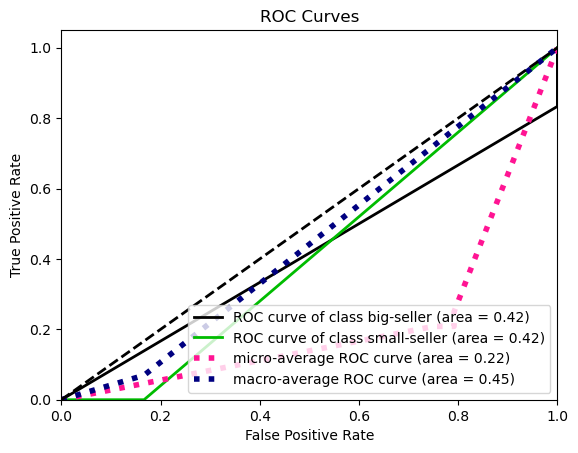

In [90]:
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rip)
plt.show()

Ripper doesn't perform too well on this dataset, again probably due to the low data points count.

## Multi-layer Perceptron

In [112]:
param_dist_mlp = {
    'solver': ["sgd", "adam"],
    'alpha': np.linspace(0, 1, 100),
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(x,) for x in range(10, 100, 10)],
    'max_iter': [300]
}

clf = MLPClassifier()
grid_search_mlp = RandomizedSearchCV(clf, param_distributions=param_dist_mlp,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))

grid_search_mlp.fit(train_set, train_label)

print('Best settings parameters ', grid_search_mlp.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_mlp.cv_results_['mean_test_score'][0], 
      grid_search_mlp.cv_results_['std_test_score'][0])

Best settings parameters  {'solver': 'sgd', 'max_iter': 300, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (70,), 'alpha': 0.9595959595959597}
Setting's accuracy score mean and std  0.8527272727272728 0.07144320983413999


/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/lib/python3.9/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/usr/lib/python3.9/site-packages/sklearn/svm/_base.py", line 558, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class

  warnings.warn("Estimator fit failed. The score on this train-test"


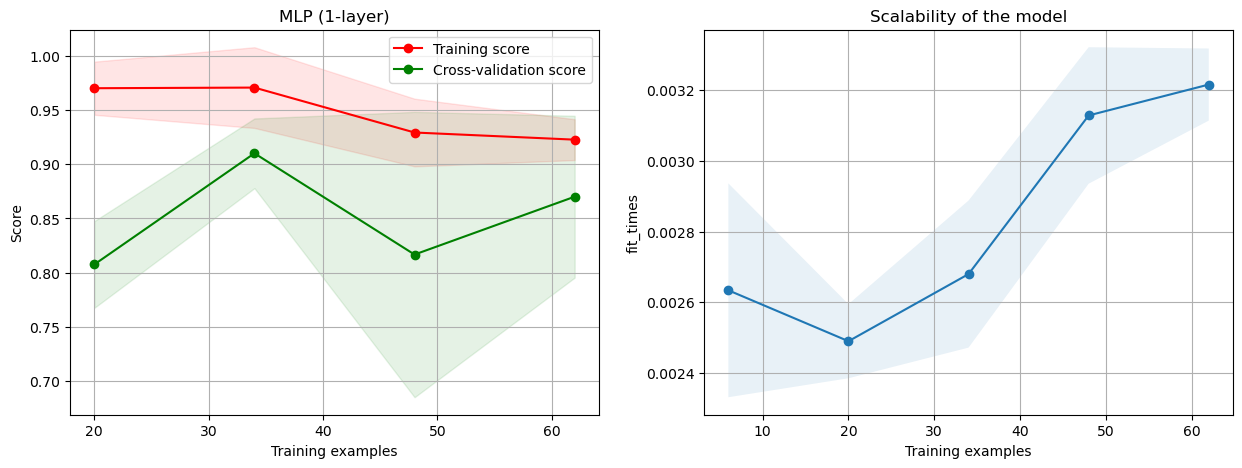

In [113]:
mlp = MLPClassifier(**grid_search_mlp.best_params_).fit(train_set, train_label)

plot_learning_curve(svm_rbf, "MLP (1-layer)", pred_df, labels)
plt.show()

In [114]:
test_pred_proba_mlp = mlp.predict_proba(test_set)
test_pred_mlp = mlp.predict(test_set)

In [115]:
report_scores(test_label, test_pred_mlp)

              precision    recall  f1-score   support

  big-seller       0.83      0.83      0.83         6
small-seller       0.94      0.94      0.94        18

    accuracy                           0.92        24
   macro avg       0.89      0.89      0.89        24
weighted avg       0.92      0.92      0.92        24



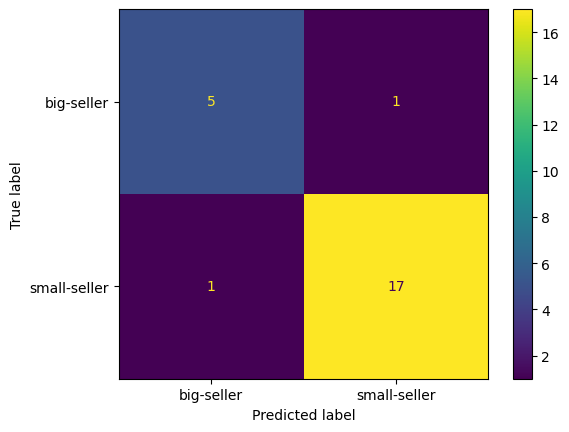

In [116]:
plot_confusion_matrix(mlp, test_set, test_label)
plt.show() 

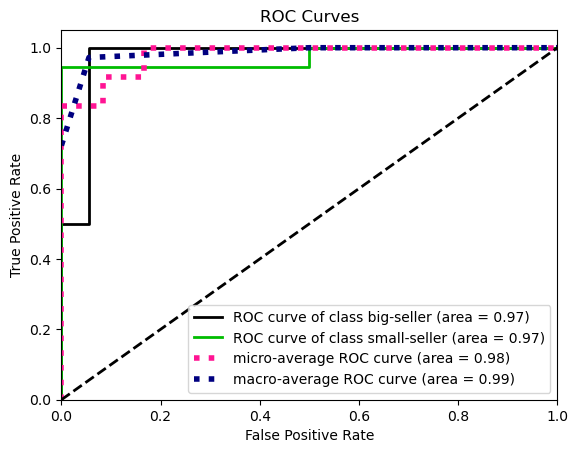

In [117]:
skplt.metrics.plot_roc(test_label.values, test_pred_proba_mlp)
plt.show()

## TODO
- Read on ripper
- Check for overfitting